# Explaining the RLS Algorithm: Outlier Processing

- #### Code by:

Pedro Henrique Meira de Andrade (Git: pedrohmeiraa) - 11/jul/2023

## 1. Definitions

## 2. Hands on!

The following code snippets utilize the methods of the RLS Filter class developed in Python. The methods include the constructor, the weight *update* method, and the *filter* method.

### 2.1 Importing modules and libraries:

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import time

### Importing our module:

In [6]:
from RLSFilter import RLSFilter

### 2.2 Importing data:

The dataset used in this notebook consists of speed data, measured in kilometers per hour, collected from a vehicle at a frequency of 1Hz.

In [2]:
data = pd.read_excel("Speed.xlsx")
data.head()

,Date,Hour,x_ant,x_atual,flag,x_antp,x_atualp,y_pred
0,01/10/2023,21:27:54,0.0,0,1,0.0,0.0,0.0
1,01/10/2023,21:27:55,0.0,0,0,0.0,0.0,0.0
2,01/10/2023,21:27:55,0.0,0,0,0.0,0.0,0.0
3,01/10/2023,21:27:56,0.0,0,0,0.0,0.0,0.0
4,01/10/2023,21:27:56,0.0,3,0,0.0,3.0,0.0


### Defining time samples:

In [3]:
t_samples = np.linspace(0, len(data), num=len(data))

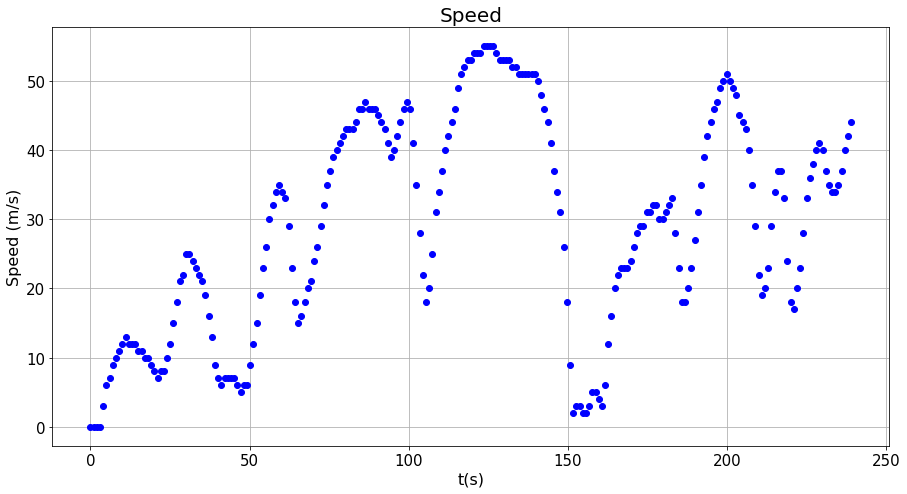

In [4]:
plt.figure(figsize=(15,7.7))
plt.grid()
plt.title("Speed", fontsize=20)
plt.plot(t_samples, data['x_atual'], 'ob', linewidth=3.5)
plt.ylabel("Speed (m/s)", fontsize=16)
plt.xlabel("t(s)", fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# 3. RLS Filter to Outlier Processing

### Defining initial conditions:

In [5]:
filter_order = 2                        #filter_order equivalent to window size
forgetting_factor = 0.99                #Forgetting factor: It is introduced to give exponentially less weight to older error samples. It is usually chosen between 0.98 and 1.
regularization_factor = 0.1             #It is usually chose between 0.1 and 1.
w0 = np.zeros(filter_order).tolist()    #Initial weights
X_ant = np.zeros(filter_order).tolist() #Initial previous input
Ya_py = []                              #Auxiliary y_pred
Y_py = []                               #Results
y_pred_py = 0.0                         #Initial predicted value

rls_filter = RLSFilter(n = filter_order, mu = forgetting_factor, delta=regularization_factor, w=w0)

#### Running:

In [6]:
for i in data['x_atual']:
    ## Acquiring the data input
    valor_atual = i

    #Saving 
    Ya_py.append(y_pred_py)

    # Updating weights
    rls_filter.update(valor_atual, np.array(X_ant))
    input_vector = []
    for j in X_ant[1:]:
        input_vector.append(j)
    input_vector.append(valor_atual)

    #Predicting the next value
    y_pred_py = rls_filter.filter(input_vector)
    Y_py.append(y_pred_py)

    #Updating previous values vector
    X_ant = input_vector

data['ya_pred_py'] = Ya_py
data['y_pred_py'] = Y_py

## Figure visualization:

In [7]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Speed Dataset"
)

figure.add_trace(
    go.Scatter(y=data['x_atual'], name='True'),
    secondary_y=False
)

figure.add_trace(
    go.Scatter(y=data['y_pred_py'], name='Predicted'),
    secondary_y=False
)

figure.update_xaxes(title='Time (s)')
figure.update_yaxes(title='Speed (m/s)', secondary_y=False)
figure.show()

# 4. Metrics evaluation:

### 4.1 Metric: MSE

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [9]:
mse = mean_squared_error(data['x_atual'], data['y_pred_py'])
mse

1.2827812457447816

In [10]:
mae = mean_absolute_error(data['x_atual'], data['y_pred_py'])
mae

0.8266216644629575

### 4.2 "Grid Search" to understand the Regularization parameter:

Now, we are going to use several **Regularization** values to see the RLS Filter behavior. In this Section, the metric used will be the mean squared error (MSE).

We are going to use as constant:
 - Initial weights = [0, 0]
 - Filter order = 2 
 - Forgetting factor = 0.99

 And we will variate the Regularization factor ($\delta$):


In [11]:
filter_order = 2                        #filter_order equivalent to window size
forgetting_factor = 0.99                #Forgetting factor: It is introduced to give exponentially less weight to older error samples. It is usually chosen between 0.98 and 1.
w0 = np.zeros(filter_order).tolist()    #Initial weights
X_ant = np.zeros(filter_order).tolist() #Initial previous input
Y_py = []                               #Results
Ya_py = []
y_pred_py = 0.0

In [12]:
# Regularization values
DELTA = [0.01, 0.1, 0.5, 0.75, 0.9, 1, 2.5, 5, 10, 20, 50, 100]

In [13]:
MSE = []
MAE = []
for delta_i in DELTA:
    rls_filter = RLSFilter(n = filter_order, mu = forgetting_factor, delta=delta_i, w=w0)
    for i in data['x_atual']:
        ## Acquiring the data input
        valor_atual = i

        #Saving 
        Ya_py.append(y_pred_py)

        # Updating weights
        rls_filter.update(valor_atual, np.array(X_ant))
        input_vector = []
        for j in X_ant[1:]:
            input_vector.append(j)
        input_vector.append(valor_atual)

        #Predicting the next value
        y_pred_py = rls_filter.filter(input_vector)
        Y_py.append(y_pred_py)

        #Updating previous values vector
        X_ant = input_vector
    
    mse = mean_squared_error(data['x_atual'], Y_py)
    mae = mean_absolute_error(data['x_atual'], Y_py)
    MSE.append(mse)
    MAE.append(mae)    
    Ya_py = []
    Y_py = []
    y_pred_py = 0.0
    w0 = np.zeros(filter_order).tolist()    #Initial weights
    X_ant = np.zeros(filter_order).tolist() #Initial previous input

## Regularization factor x MSE

In [ ]:
fig, ax = plt.subplots(figsize = (15,7.7))
ax.scatter(x=DELTA, y=MSE, linewidth=2.5, s=110, alpha=0.7, edgecolors="b")
plt.title("Regularization factor x MSE", fontsize=20)
plt.xlabel("Regularization factor", fontsize=16)
plt.ylabel("Mean squared error (MSE)", fontsize=16)
#ax.set_yscale('log')
ax.set_xscale('log')
plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
plt.grid()
plt.show()

## Regularization factor x MAE

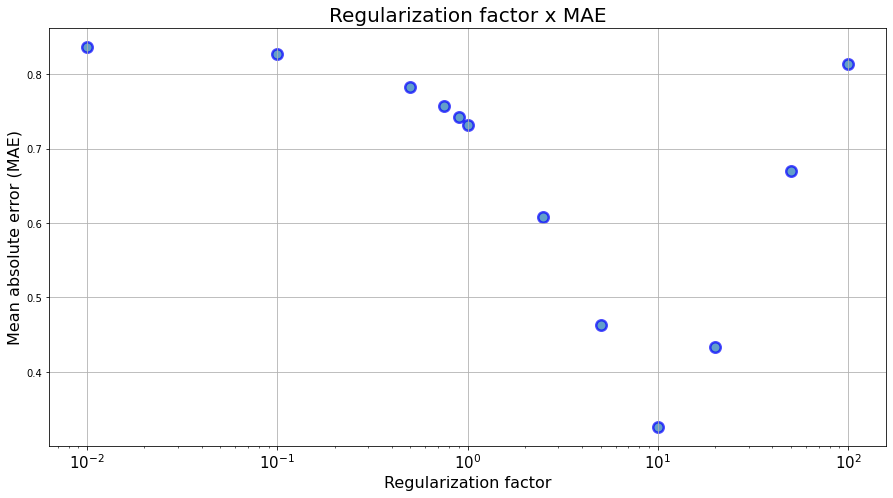

In [17]:
fig, ax = plt.subplots(figsize = (15,7.7))
ax.scatter(x=DELTA, y=MAE, linewidth=2.5, s=110, alpha=0.7, edgecolors="b")
plt.title("Regularization factor x MAE", fontsize=20)
plt.xlabel("Regularization factor", fontsize=16)
plt.ylabel("Mean absolute error (MAE)", fontsize=16)
#ax.set_yscale('log')
ax.set_xscale('log')
plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
plt.grid()
plt.show()

# 5. WandB

## 5.1 WandB importing

In [18]:
#!pip install wandb

In [19]:
import wandb
import logging

In [20]:
!wandb login 40f0acf51f839c9bfbed5c1f24e945ed8245e110

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Samsung/.netrc


#### Initialize a new W&B run to track this job

In [21]:
run = wandb.init(project="TEDARegressor", job_type="dataset-creation")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedrohmeira (embarca-ai). Use `wandb login --relogin` to force relogin


In [22]:
# Create a new artifact, which is a sample dataset
dataset = wandb.Artifact('Speed', type='dataset')
# Add files to the artifact, in this case a simple text file
dataset.add_file('Speed.xlsx')
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

### Configure logging:

In [23]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

### Defining dictionaries:

1. Metric dictionary:

In [24]:
metric_dict = {
    'name': 'mse',
    'goal': 'minimize'   
    }

2. Parameters dictionary:

In [25]:
parameters_dict = {
    #RLS
    'FilterOrder': {
      'values': [2,3,4]
    },
    'Forgetting': {
          'values': [0.1, 0.5, 0.75, 0.98, 0.99, 0.999, 1]
        },    
    'Regularization': {
          'values': [0.01, 0.1, 0.5, 0.75, 0.9, 1, 2.5, 5, 10, 20, 50, 100]         
        },
}

### Defining Sweep:

In [26]:
seed = 41
sweep_config = {
    "method": "grid",
    "metric": metric_dict,
    "parameters": parameters_dict,

}
sweep_id = wandb.sweep(sweep_config, project="TEDARegressor")

Create sweep with ID: 75l4ftw2
Sweep URL: https://wandb.ai/embarca-ai/TEDARegressor/sweeps/75l4ftw2


### Training:

In [27]:
def train():
    with wandb.init() as run:
        N_order = wandb.config.FilterOrder
        Ya_py = []
        Y_py = []
        y_pred_py = 0
        w0 = np.zeros(N_order).tolist()    #Initial weights
        X_ant = np.zeros(N_order).tolist() #Initial previous input     
        
        rls_filter = RLSFilter(n = N_order, mu = wandb.config.Forgetting, delta=wandb.config.Regularization, w=w0)
        
        for i in data['x_atual']:
            ## Acquiring the data input
            valor_atual = i

            #Saving 
            Ya_py.append(y_pred_py)

            # Updating weights
            rls_filter.update(valor_atual, np.array(X_ant))
            input_vector = []
            for j in X_ant[1:]:
                input_vector.append(j)
            input_vector.append(valor_atual)

            #Predicting the next value
            y_pred_py = rls_filter.filter(input_vector)
            Y_py.append(y_pred_py)

            #Updating previous values vector
            X_ant = input_vector
        
        mse = mean_squared_error(data['x_atual'], Y_py)
        mae = mean_absolute_error(data['x_atual'], Y_py)
        MSE.append(mse)
        MAE.append(mae)
        Ya_py = []
        Y_py = []
        y_pred_py = 0
        w0 = np.zeros(N_order).tolist()    #Initial weights
        X_ant = np.zeros(N_order).tolist() #Initial previous input

        # MSE
        run.summary['mse'] = mse
        wandb.log({"mse": mse})
        # MAE
        run.summary['mae'] = mae
        wandb.log({"mae": mae})        

In [ ]:
wandb.agent(sweep_id, train)

## 5.2 Visualization Results

Here, we can visualize the Sweep Results 👀. We have use the **Parallel Coordinates Plot 🔀** to map hyperparameter values to model metrics.
We've used to see the combinations of hyperparameters that led to the **best model performance (minor MSE) 📊**:


#### RLS Sweep - Speed Data

![RLS Sweep - Speed Data](figures/Speed/Speed_sweep.png)

## Best Setup -> Minor MSE:
### - MSE = 0.2407
### - MAE = 0.2886
 - Filter order: 2
 - Forgetting factor ($\lambda$): 1
 - Regularization factor ($\delta$): 10

## MSE Parameter Importance:

![Parameter Importance - Speed Data](figures/Speed/Speed_parameter_importance_MSE.png)

## MAE Parameter Importance:

![Parameter Importance - Speed Data](figures/Speed/Speed_parameter_importance_MAE.png)

In [10]:
MSE_parameter_importance = pd.read_excel("figures/Speed/Speed_parameter_importance_MSE.xlsx")
MSE_parameter_importance.head()

,Config parameter,Importance,Correlation
0,Forgetting,0.626,-0.759
1,Regularization,0.321,0.430
2,Filter Order,0.054,0.347


In [11]:
MAE_parameter_importance = pd.read_excel("figures/Speed/Speed_parameter_importance_MAE.xlsx")
MAE_parameter_importance.head()

,Config parameter,Importance,Correlation
0,Forgetting,0.479,0.586
1,Regularization,0.339,-0.605
2,Filter Order,0.182,0.551


# 6. References

[[1]](https://www.researchgate.net/publication/301411485_Anomaly_detection_based_on_eccentricity_analysis) Angelov, Plamen. (2014). *Anomaly detection based on eccentricity analysis*. 1-8. 10.1109/EALS.2014.7009497. 



[[2]](https://www.mdpi.com/1424-8220/22/10/3838) Andrade, P.; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. Sensors 2022, 22, 3838. doi: 10.3390/s22103838

[[3]](https://ieeexplore.ieee.org/document/536707) A. Bernieri, G. Betta and C. Liguori, *"On-line fault detection and diagnosis obtained by implementing neural algorithms on a digital signal processor"* in IEEE Transactions on Instrumentation and Measurement, vol. 45, no. 5, pp. 894-899, Oct. 1996, doi: 10.1109/19.536707.